In [14]:
import pdb 
import os 
import pickle 
import json 
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel,ttest_ind, ttest_1samp
import scipy
from matplotlib import pyplot as plt 
import seaborn as sns 
from io import BytesIO
import math 
from sklearn.metrics import adjusted_rand_score 
import requests
# humanUtils
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/humanUtils.py")
with open('humanUtils.py', 'w') as f:
    f.write(r.text)
from humanUtils import * 
# analysis
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/analysis.py")
with open('analysis.py', 'w') as f:
    f.write(r.text)
from analysis import *
# utils 
r = requests.get("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/utils.py")
with open('utils.py', 'w') as f:
    f.write(r.text)
from utils import * 
sns.set_context('talk')
plt.rcParams['font.size'] = 22
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# constants for plot making

In [15]:
cLD = {
  'blocked': ['green','blue', 'green','blue', 'red'],
  'blocked_rep': ['green','blue', 'green','blue', 'red'],
  'interleaved': ['gold','gold','gold','gold','red'],
  'interleaved_rep': ['gold','gold','gold','gold','red'],
  'inserted_early': ['blue','green','yellow','yellow','red'],
  'early': ['blue','green','yellow','yellow','red'],
  'inserted_early_rep': ['blue','green','yellow','yellow','red'],
  'inserted_middle': ['yellow','blue','green','yellow','red'],
  'middle': ['yellow','blue','green','yellow','red'],
  'inserted_middle_rep': ['yellow','blue','green','yellow','red'],
  'inserted_late': ['yellow','yellow','blue','green','red'],
  'late': ['yellow','yellow','blue','green','red'],
  'inserted_late_rep': ['yellow','yellow','blue','green','red'],
  'explicit_interleaved': ['purple','purple','purple','purple','red'],
}

TITLES_ON = False
condL = ['blocked','interleaved','early','middle','late']
fig_save_path = "figures/"

# human dataframe

## load and save dataframes from each experiemnt

In [16]:
## load and save
dfD = {}
for cond in ALL_CONDITIONS:
  for thresh in [0.9,0]:
    fname = f"{cond}_thresh{int(thresh*100)}.csv"
    df = pd.read_csv(f'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/{fname}')
    dfD[cond,thresh] = df   
human_df = pd.concat(dfD,names=['condition','thresh'])

## additional formating to human df

In [17]:
# additional columns
human_df.loc[:,'score'] = human_df.correct_response
human_df.loc[:,'response_node'] = human_df.apply(lambda r: [r.false_tonode,r.true_tonode][r.correct_response],axis=1)
node2stateD = {
  "BEGIN":0,
  "LOCNODEB":1,
  "LOCNODEC":2,
  "NODE11":3,
  "NODE12":4,
  "NODE21":5,
  "NODE22":6,
  "NODE31":7,
  "NODE32":8,
  "END":9
}
human_df.loc[:,'rfc_int'] = (human_df.true_rfc.str.split('-').str[-1].str.lower()=='jungle').astype('int')
human_df.loc[:,'response_node_int'] = human_df.apply(lambda r: node2stateD[r.response_node],axis=1)
# finalize
human_df = human_df
print(human_df.columns)
human_df.head()



Index(['subjnum', 'block', 'story', 'depth', 'Unnamed: 4', 'type', 'qtype',
       'state', 'fromnode', 'true_tonode', 'false_tonode', 'rfc', 'true_rfc',
       'false_rfc', 'response_right', 'true_on_right', 'correct_response',
       'edge', 'score', 'response_node', 'rfc_int', 'response_node_int'],
      dtype='object')


subjnum  block  story  depth  Unnamed: 4      type  \
condition thresh                                                         
blocked   0.9    0        6      0      0      1          11  question   
                 1        6      0      0      2          15  question   
                 2        6      0      1      1          30  question   
                 3        6      0      1      2          34  question   
                 4        6      0      2      1          49  question   

                     qtype  state fromnode true_tonode  ...  \
condition thresh                                        ...   
blocked   0.9    0  transQ    NaN   NODE11      NODE22  ...   
                 1  transQ    NaN   NODE22      NODE31  ...   
                 2  transQ    NaN   NODE11      NODE22  ...   
                 3  transQ    NaN   NODE22      NODE31  ...   
                 4  transQ    NaN   NODE11      NODE22  ...   

                                           true_rfc  \
condition thresh                                      
blocked   0.9    0  subject-Beverly_location-jungle   
                 1  subject-Beverly_location-jungle   
                 2    subject-Jacob_location-jungle   
                 3    subject-Jacob_location-jungle   
                 4   subject-Denise_location-jungle   

                                          false_rfc response_right  \
condition thresh                                                     
blocked   0.9    0  subject-Beverly_location-jungle           True   
                 1  subject-Beverly_location-jungle           True   
                 2    subject-Jacob_location-jungle           True   
                 3    subject-Jacob_location-jungle           True   
                 4   subject-Denise_location-jungle           True   

                   true_on_right  correct_response          edge  score  \
condition thresh                                                          
blocked   0.9    0         False                 0  NODE11NODE22      0   
                 1         False                 0  NODE22NODE31      0   
                 2          True                 1  NODE11NODE22      1   
                 3          True                 1  NODE22NODE31      1   
                 4          True                 1  NODE11NODE22      1   

                   response_node  rfc_int response_node_int  
condition thresh                                             
blocked   0.9    0        NODE21        1                 5  
                 1        NODE32        1                 8  
                 2        NODE22        1                 6  
                 3        NODE31        1                 7  
                 4        NODE22        1                 6  

[5 rows x 22 columns]

# plots organized by flow

In [18]:

human_df.query("condition==['blocked_rep']&thresh==0.9").reset_index()#.subjnum.unique()

,condition,thresh,level_2,subjnum,block,story,depth,Unnamed: 4,type,qtype,...,true_rfc,false_rfc,response_right,true_on_right,correct_response,edge,score,response_node,rfc_int,response_node_int
0,blocked_rep,0.9,0,0,0,0,1,9,question,transQ,...,subject-Diana_location-deep,subject-Diana_location-deep,False,True,0,NODE12NODE22,0,NODE21,0,5
1,blocked_rep,0.9,1,0,0,1,2,30,question,transQ,...,subject-Peter_location-deep,subject-Peter_location-deep,True,True,1,NODE21NODE31,1,NODE31,0,7
2,blocked_rep,0.9,2,0,0,2,1,45,question,transQ,...,subject-Cynthia_location-deep,subject-Cynthia_location-deep,False,False,1,NODE12NODE22,1,NODE22,0,6
3,blocked_rep,0.9,3,0,0,2,2,49,question,transQ,...,subject-Cynthia_location-deep,subject-Cynthia_location-deep,False,False,1,NODE22NODE32,1,NODE32,0,8
4,blocked_rep,0.9,4,0,0,3,2,68,question,transQ,...,subject-Kyle_location-deep,subject-Kyle_location-deep,False,True,0,NODE22NODE32,0,NODE31,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,blocked_rep,0.9,7747,60,4,197,1,3594,question,transQ,...,subject-Justin_location-jungle,subject-Justin_location-jungle,False,False,1,NODE11NODE22,1,NODE22,1,6
7748,blocked_rep,0.9,7748,60,4,197,2,3598,question,transQ,...,subject-Justin_location-jungle,subject-Justin_location-jungle,False,False,1,NODE22NODE31,1,NODE31,1,7
7749,blocked_rep,0.9,7749,60,4,198,1,3611,question,transQ,...,subject-Noah_location-deep,subject-Noah_location-deep,False,False,1,NODE11NODE21,1,NODE21,0,5
7750,blocked_rep,0.9,7750,60,4,198,2,3615,question,transQ,...,subject-Noah_location-deep,subject-Noah_location-deep,True,True,1,NODE21NODE31,1,NODE31,0,7


In [19]:
def lineplt_single(cond,thresh,transition=None,ax=None,fgkw={},figname="none"):
  
  plt.figure(figsize=(12,6))
  condL=[cond]
  if not ax:
    ax = plt.gca()
  df_plt = human_df.query("condition==@condL&thresh==@thresh").reset_index()
  print(df_plt.thresh.unique())
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  g = sns.lineplot(data=df_plt,x='story',y='score',ax=ax,**fgkw)
  ax.axhline(0.5,c='k')
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('trial')
  # background color
  color_background(ax,cond)
  if TITLES_ON:
    ax.set_title("cond=%s-filter=%.2f-transition=%s"%(cond,thresh,transition))
  return g

def color_background(ax,cond):
  for idx in range(5):
      ax.fill_between(
        np.arange(40*idx,41+40*idx),
        0,1.05,
        color=cLD[cond][idx],
        alpha=0.2
    )

def lineplt(condL,thresh,transition=None,ax=None,fgkw={},figname="none"):
  for cond in condL:
    lineplt_single(cond,thresh,transition=transition,ax=ax,fgkw=fgkw,figname=figname)

def beetestplt(condL,thresh,transition=None,figname="none"):

  plt.figure(figsize=(12,6))
  ax = plt.gca()
  df_plt = human_df.query(f"condition==@condL&thresh==@thresh").reset_index()
  if transition:
    assert transition in [1,2]
    df_plt = df_plt.query(f"depth=={transition}")
  dftest_plt = df_plt.query("block==4")
  g = sns.violinplot(data=dftest_plt.groupby(['subjnum','condition']).mean().reset_index(),
                x='condition',y='score',hue_order='condition',ax=ax,order=condL
               )
  ax.set_ylabel('prediction accuracy')
  if TITLES_ON:
    ax.set_title("cond=%s-filter=%.2f-transition=%s"%(cond,thresh,transition))
  return g

### Figure 3 a-c

[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

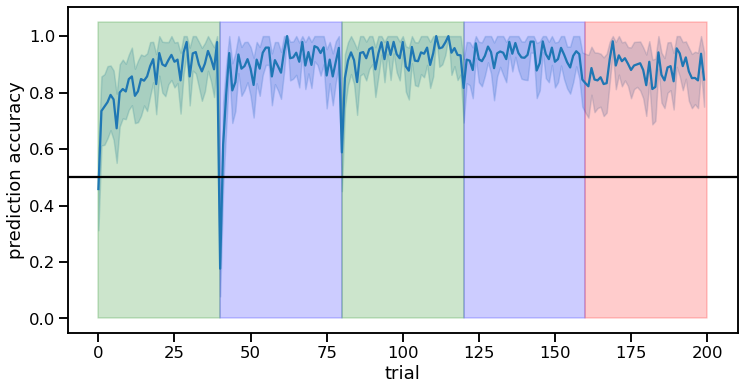

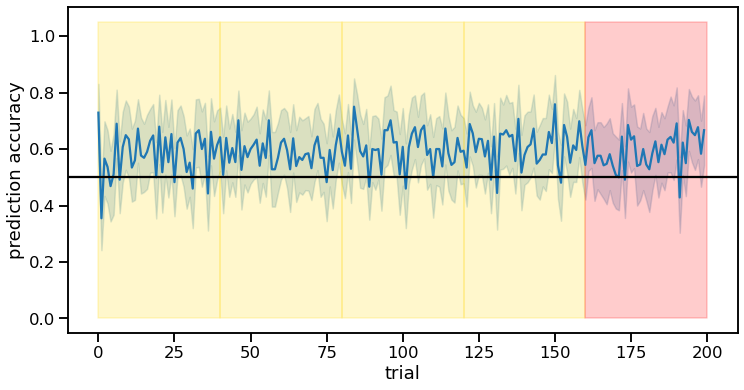

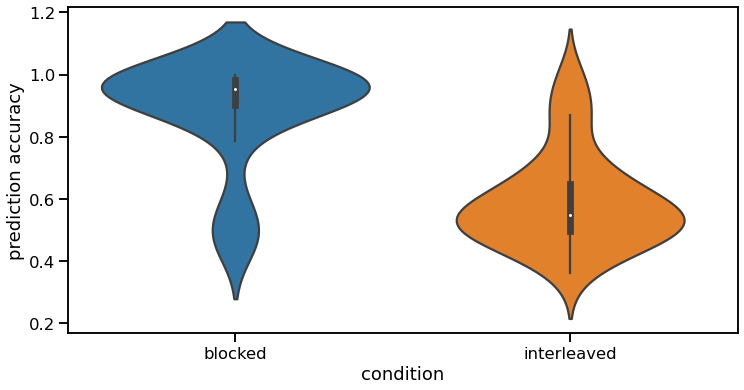

In [20]:
n = 'humanBI'
lineplt(['blocked','interleaved'],0.9,figname=n)
beetestplt(['blocked','interleaved'],0.9,figname=n)

### Figure 3 d-f

[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

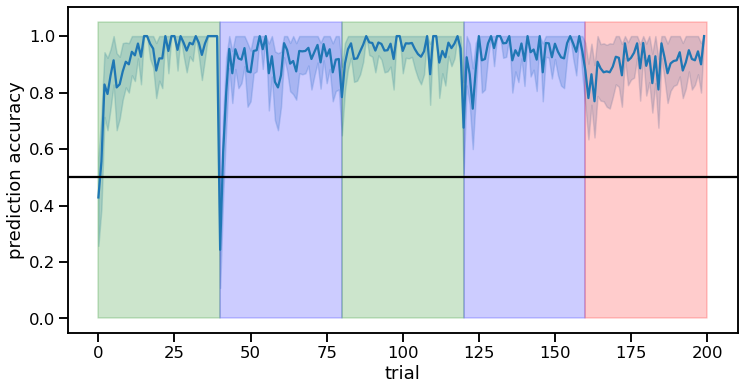

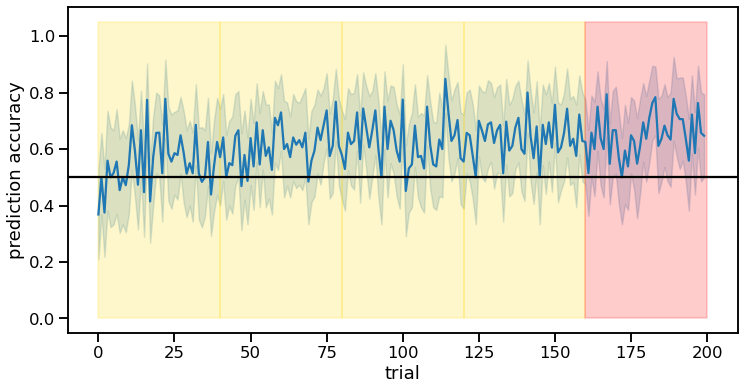

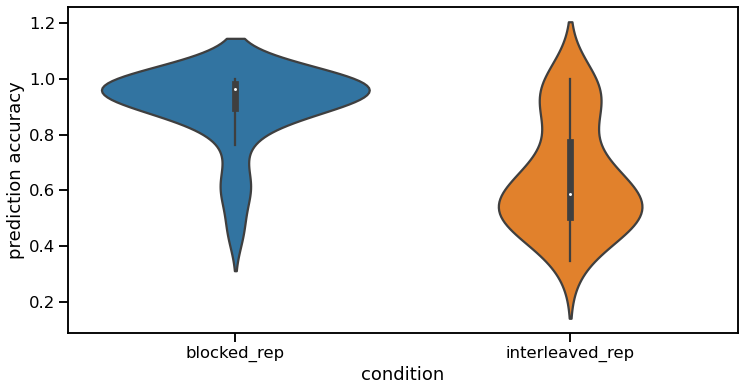

In [21]:
lineplt(['blocked_rep', 'interleaved_rep'],thresh = 0.9)
beetestplt(['blocked_rep','interleaved_rep'],0.9)

### Figure 4

[0.9]


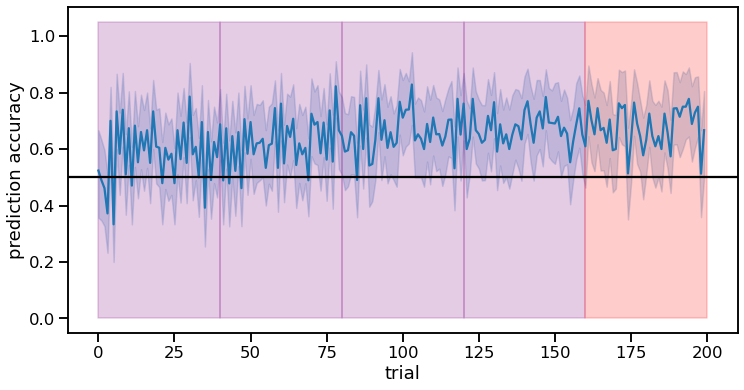

In [22]:
n='explic'
lineplt(['explicit_interleaved'],0.9,figname=n)

# Figure 5

In [ ]:
df_amt1 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/amt1_N=48.xlsx')
df_amt2 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/amt2_N=127.xlsx')
df_onsite = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/onsite_N=30.xlsx.xlsx')


# g = sns.catplot(data=tips, x="day", y="total_bill", kind="violin", inner=None)
# sns.swarmplot(data=tips, x="day", y="total_bill", color="k", size=3, ax=g.ax)

# Figure 6 a & b


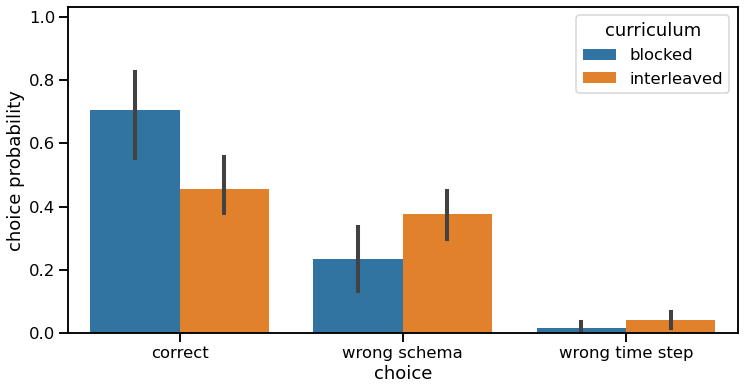

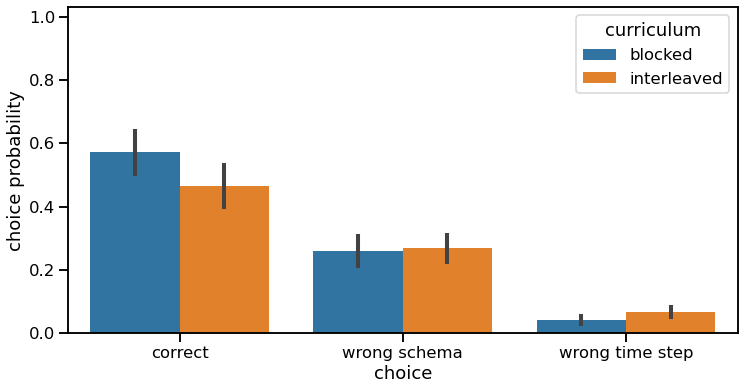

In [23]:
def plt_data(df):
  plt.figure(figsize=(12,6))
  ax = plt.gca()
  df.loc[:,"wrong time step"] = df.loc[:,"wrong time step"]/4
  df = df.melt(id_vars='curriculum',value_vars=['correct',"wrong schema", "wrong time step"])
  df.value = df.value/100
  sns.barplot(
    data=df,
    x='variable',y='value',hue='curriculum',ax=ax,hue_order=['blocked','interleaved'],ci=95
  )
  ax.set_ylabel('choice probability')
  ax.set_xlabel('choice')
  ax.set_ylim(0,1.03)
  
## PROCESSSING
A,B = "wrong schema", "wrong time step"

df1.columns = [*df1.columns[:2],A,B,'curriculum']

## ONSITE PLOT
l = plt_data(df1)

# PROCESSING 2
df2 = pd.read_excel('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/AV_data_onlineExpt.xlsx')
df2.columns = ['curriculum',df2.columns[1],A,B]

# ONLINE PLOT
plt_data(df2)


# modeling

## load model dfs

In [24]:
model_acc_df = pd.read_csv(f"https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_acc_df.csv")
model_states_df = pd.read_csv("https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/sims_states_df.csv")
model_acc_df.loc[:,'cond_int'] = model_acc_df.cond
model_states_df.loc[:,'cond_int'] = model_states_df.cond

## plotting functions

In [25]:
model_acc_df.cond = model_acc_df.cond.apply(lambda x: {
  0:'blocked',1:'interleaved',2:'early',3:'middle',4:'late'
}[x])

In [26]:

def lineplot_model(gsname,condstr,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  ax.axhline(0.5,c='k')
  sns.lineplot(
    data=model_acc_df.query(f"gs=='{gsname}'&{condstr}"
                  ).groupby(['trial','cond']).mean().reset_index(),
    x='trial',y='acc',hue='cond',ax=ax
  )
  ax.set_ylabel('prediction accuracy')  
  ax.legend().remove()
  if TITLES_ON:
    ax.set_title(gsname+" COND-"+condstr)
  return ax
  
def lineplot_modelBI(gsname,ax=None):
  for ix in [0,1]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}',ax=None)
    color_background(ax,['blocked','interleaved'][ix])

def lineplot_modelEML(gsname):
  for ix in [2,3,4]:
    ax=lineplot_model(gsname,condstr=f'cond_int=={ix}',ax=None)
    color_background(ax,['early','middle','late'][ix-2])

def beeswarm_model(gsname,condstr,ax=None):
  if not ax:
    plt.figure(figsize=(12,6))
    ax = plt.gca()
  sns.violinplot(
    data=model_acc_df.query(f"gs=='{gsname}'&test==True&{condstr}"
                  ).groupby(['seed','cond']).mean().reset_index(),
    x='cond',y='acc',ax=ax
  )
  ax.set_ylabel('prediction accuracy')
  ax.set_xlabel('condition')
  if TITLES_ON:
    ax.set_title(gsname+" COND-"+condstr)

def beeswarm_modelBI(gsname):
  beeswarm_model(gsname,condstr='cond_int<2')

def beeswarm_modelEML(gsname):
  beeswarm_model(gsname,condstr='cond_int>=2')


In [27]:
def scatter_adjrand_vs_acc(gsname,ax=None,tstep=[1,2]):
  if not ax:
    plt.figure()
    ax=plt.gca()
  for six in range(100):
    q = f"seed=={six} & gs=='{gsname}'& cond_int==1 & trial>=160"
    sdf_states = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean()
    adjrand = adjusted_rand_score(
      sdf_states.query('tstep==%i'%tstep[0]).exp,
      sdf_states.query('tstep==%i'%tstep[1]).xth
    )
    ax.scatter(adjrand,sacc,c='k')
  ax.set_xlabel('adjusted rand')
  ax.set_ylabel('acc')
  ax.set_title(gsname)
  # plt.savefig(fig_save_path+'png/model/scatter_adjrand_vs_acc-%s.png'%(gsname))
  # plt.savefig(fig_save_path+'svg/model/scatter_adjrand_vs_acc-%s.svg'%(gsname))
  


# Figure 7

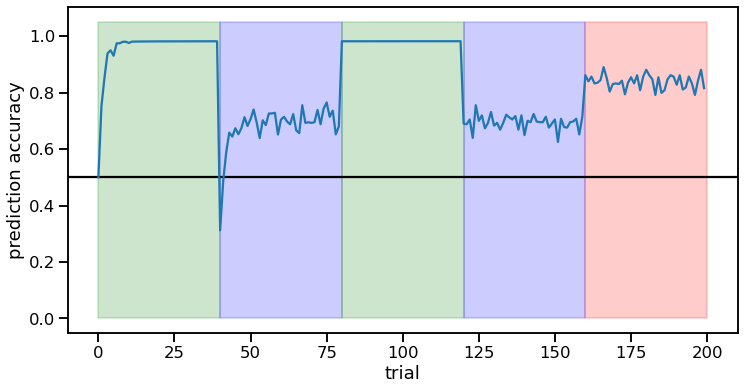

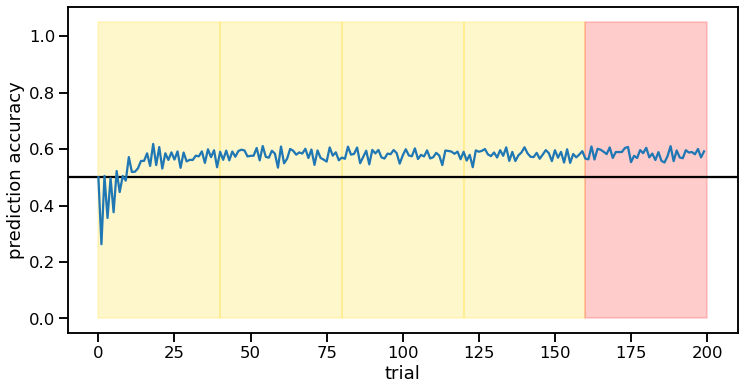

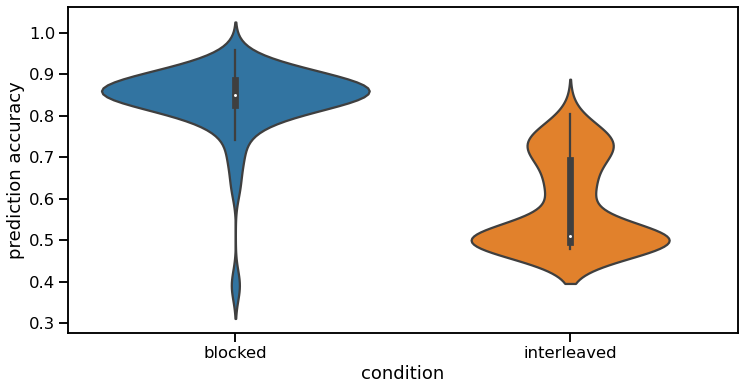

In [28]:
gsname = "sim1"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

# Figure 8 a-c

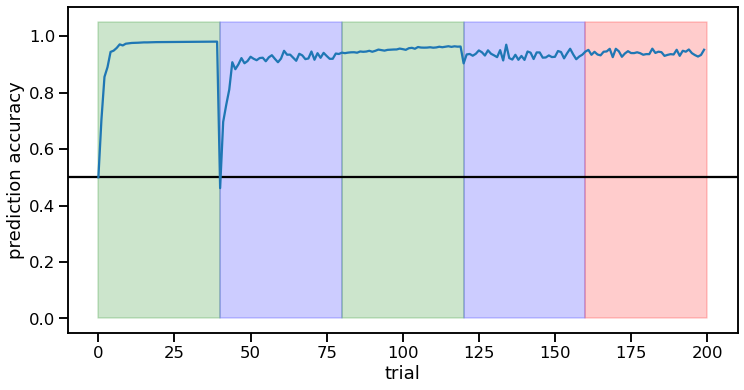

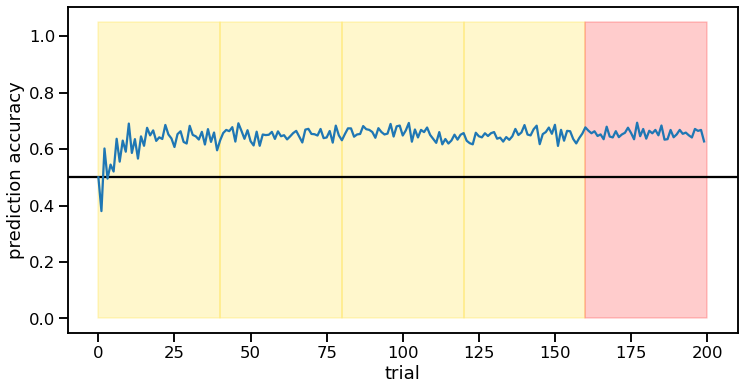

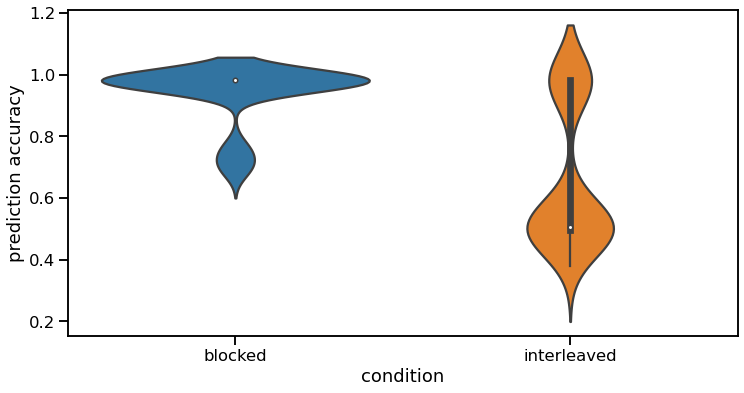

In [29]:
gsname = 'sim2'
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

# Figure 8 d

 no rep pid_acc_list:  39
rep pid_acc_list:  63


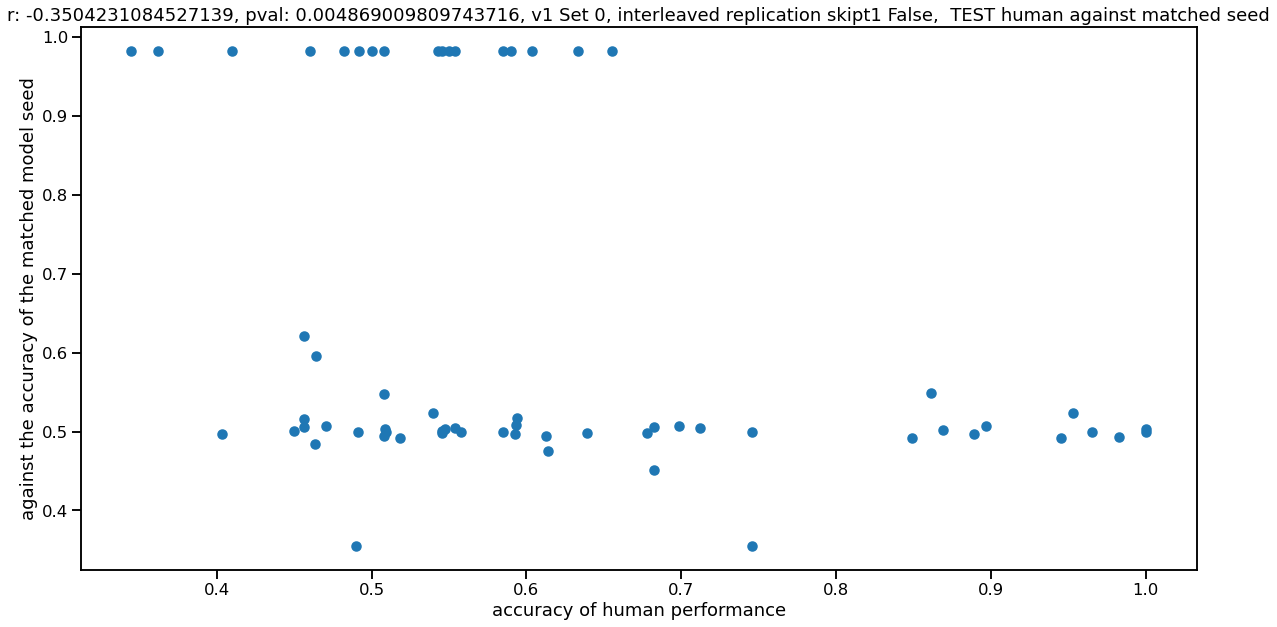

In [30]:
# get the scatter plots 
gsname = 'sim2'
gsdf = pd.read_csv('https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/model/%s-summdf.csv'%gsname).astype(float) # for each grid we have the mse for the various conditions
gsdf.loc[:,"mse-bi"] = gsdf.b_mse1+gsdf.b_mse2+gsdf.i_mse1+gsdf.i_mse2
TOP_K = 1
## select top40 MSE
topKgsdf = gsdf.sort_values('mse-bi').iloc[:TOP_K]
## LOOP
for rank,(idx,row) in enumerate(topKgsdf.iterrows()):
  param_set_num = rank
  args,paramstr = get_argsD(row)

  # INTERLEAVED
  participant_to_exp_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleaved_participant_to_exp.pickle'
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials
  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleaved_participant_to_testAcc.pickle'
  participant_to_testAcc = pickle.load(BytesIO(requests.get(participant_to_testAcc_path).content))
  pid_acc_list = []
  matched_seed_acc_list = []
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print(" no rep pid_acc_list: ", len(pid_acc_list))
  
  # interleaved rep
  participant_to_exp_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleavedRep_participant_to_exp.pickle'
  participant_to_measures = run_exps_feedHumanExp_v7(participant_to_exp_path, args)
  raw_acc = unpack_acc_feedHuman_v7(participant_to_measures,mean_over_tsteps=False) # curr,seeds,tsteps,trials
  each_matched_seed_acc = raw_acc[:,:,160:].mean((1,2)).tolist()
  participant_to_testAcc_path = 'https://raw.githubusercontent.com/PrincetonCompMemLab/blocked_training_facilitates_learning/master/data/human/versionX_interleavedRep_participant_to_testAcc.pickle'
  participant_to_testAcc = pickle.load(BytesIO(requests.get(participant_to_testAcc_path).content))
  for pid in sorted(list(participant_to_testAcc.keys())):
    matched_seed_acc_list.append(each_matched_seed_acc[pid])
    pid_acc_list.append(participant_to_testAcc[pid])
  print("rep pid_acc_list: ", len(pid_acc_list))
  plt.figure(figsize=(20,10))
  plt.scatter(pid_acc_list,matched_seed_acc_list)
  plt.xlabel("accuracy of human performance")
  plt.ylabel("against the accuracy of the matched model seed")
  r, pval = scipy.stats.pearsonr(pid_acc_list,matched_seed_acc_list)
  plt.title("r: " + str(r) + ", pval: " + str(pval) + ", v1 Set " + str(param_set_num) + ", interleaved replication skipt1 False,  TEST human against matched seed")



# Figure 9


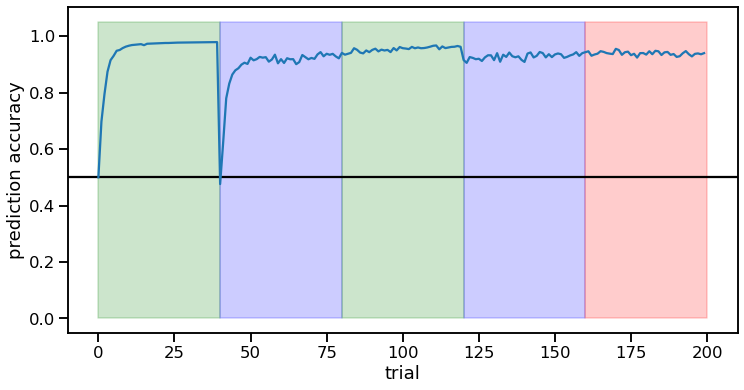

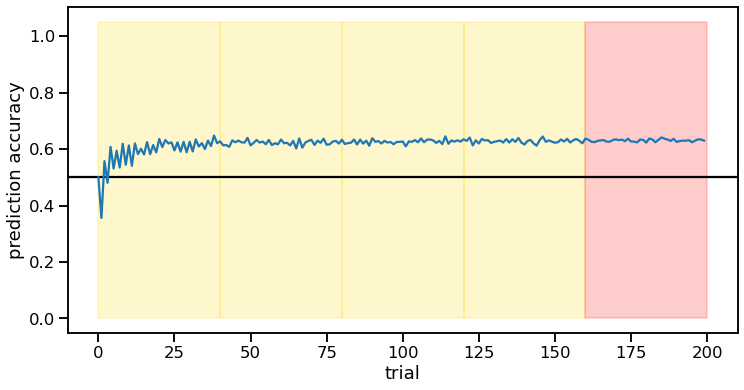

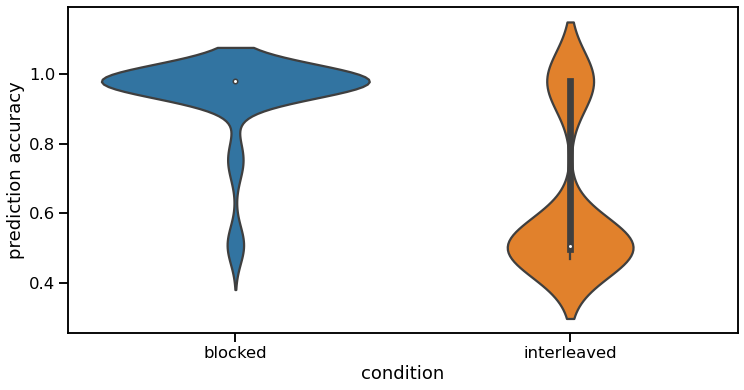

In [31]:
gsname="sim3"
lineplot_modelBI(gsname)
beeswarm_modelBI(gsname)

In [32]:
def scatter_numlc_vs_acc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(10,8))
    ax=plt.gca()
  cond = 1
  for six in range(100):
    q = f"gs=='{gsname}'&cond_int=={cond}&trial>=160&seed=={six}"
    seed_states_df = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    nlc = seed_states_df.zt.max()+1
    ax.scatter(nlc,sacc,c='k')
  ax.set_ylabel('test accuracy')
  ax.set_xlabel('number of latent causes')
  if TITLES_ON:
    ax.set_title(gsname)
  # plt.savefig(fig_save_path+'png/model/scatter_numlc_vs_acc-%s.png'%(gsname))
  # plt.savefig(fig_save_path+'svg/model/scatter_numlc_vs_acc-%s.svg'%(gsname))
  
def scatter_concentration_vs_numlc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(10,8))
    ax=plt.gca()
  q = f"gs=='{gsname}'&cond==1"
  for six,sdf in model_states_df.query(q).groupby('seed'):
    numlc=sdf.zt.max()
    ax.scatter(sdf.alpha.unique(),numlc+1,c='k')
  ax.set_xlabel('concentration')
  ax.set_ylabel('number of latent causes')
  if TITLES_ON:
    ax.set_title(gsname)

def scatter_concentration_vs_acc(gsname,ax=None):
  if not ax:
    plt.figure(figsize=(10,8))
    ax=plt.gca()
  cond=1
  for six in range(100):
    q = f"gs=='{gsname}'&cond_int=={cond}&trial>=160&seed=={six}"
    seed_states_df = model_states_df.query(q)
    sacc = model_acc_df.query(q).acc.mean() 
    alpha = model_states_df.query(q).alpha.unique()[0]
    ax.scatter(alpha,sacc,c='k')
  ax.set_xlabel('concentration')
  ax.set_ylabel('test accuracy')
  if TITLES_ON:
    ax.set_title(gsname)
  return None

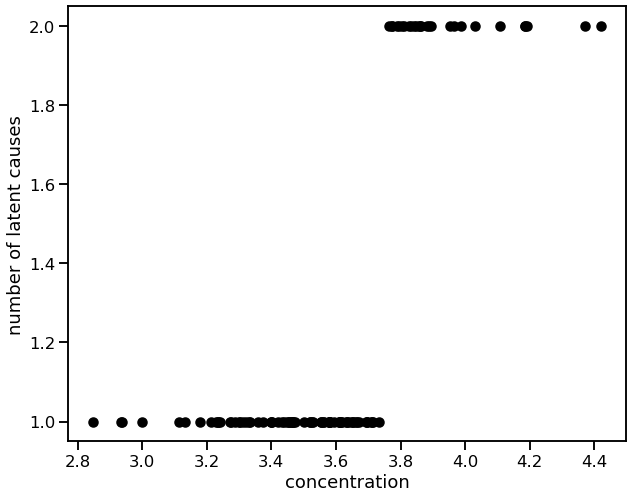

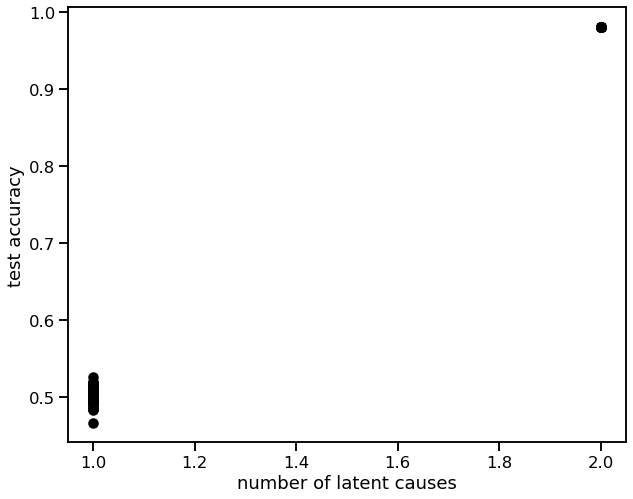

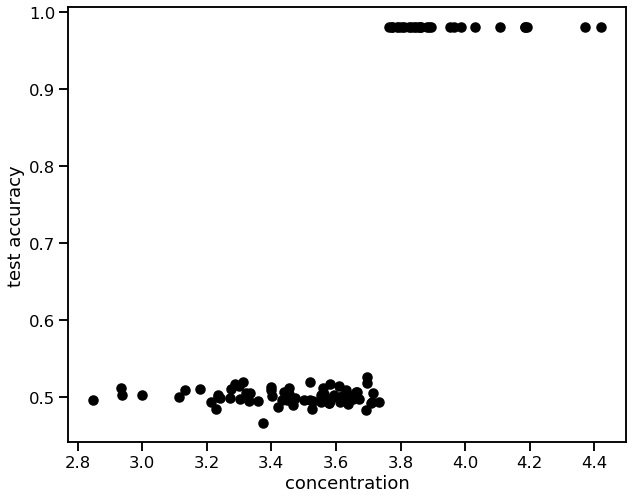

In [33]:


scatter_concentration_vs_numlc("sim3")
scatter_numlc_vs_acc("sim3")
scatter_concentration_vs_acc("sim3")

# Figure 10 a-d

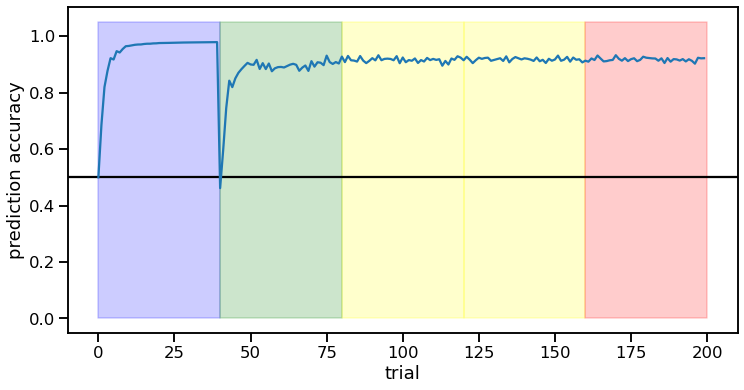

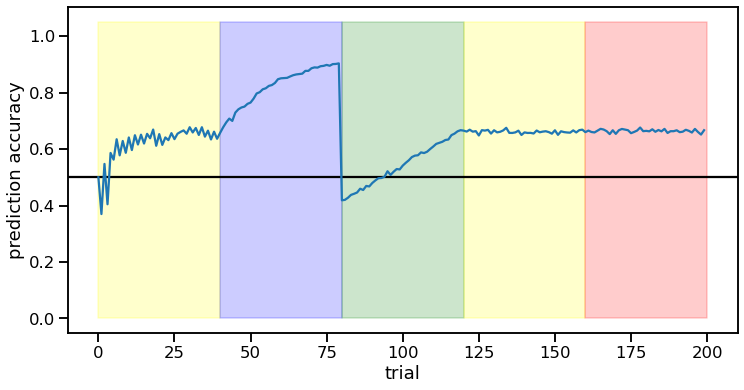

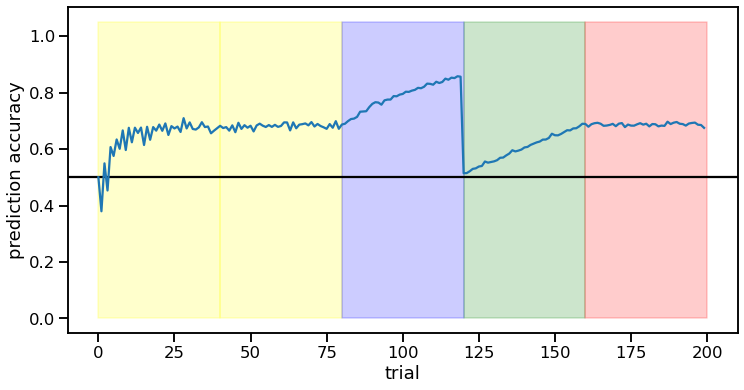

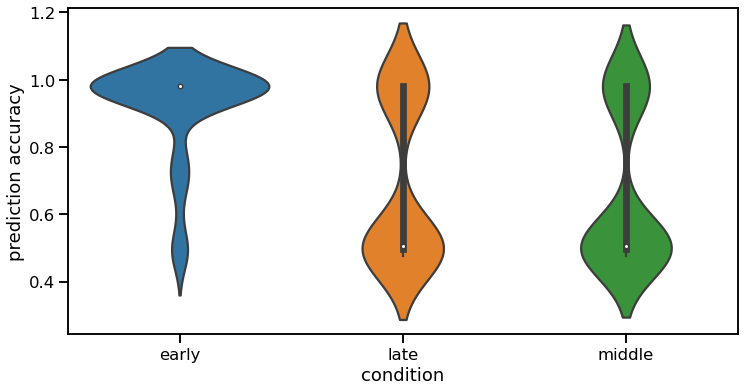

In [34]:
gsname="sim3"
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)

# Figure 10 e-h

[0.9]
[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

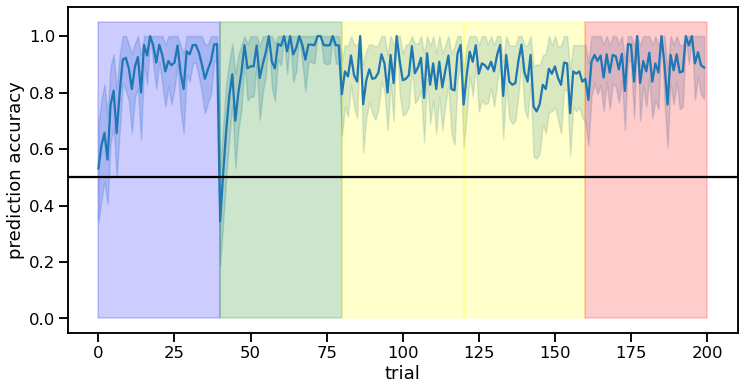

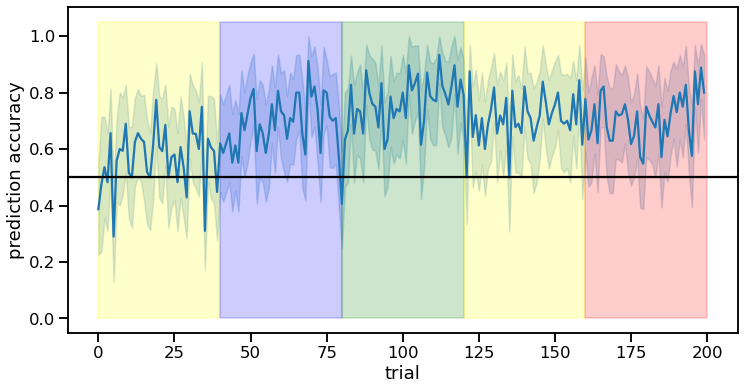

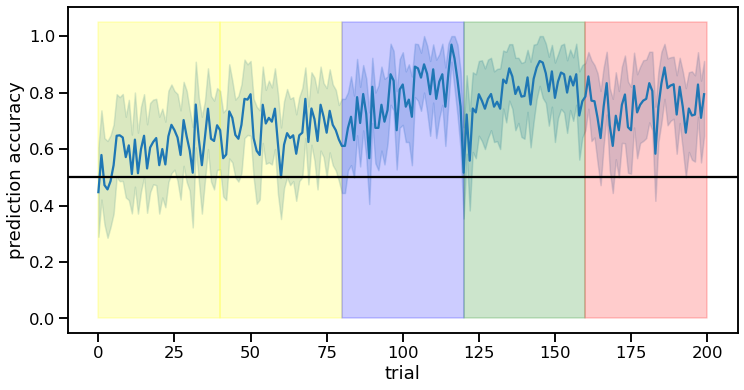

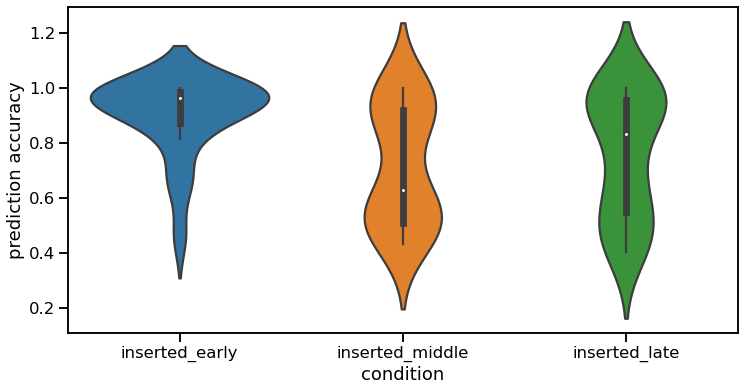

In [35]:
condL = ['inserted_early','inserted_middle','inserted_late']
lineplt(condL,0.9)
beetestplt(condL,0.9)

# Figure 10 i-l

[0.9]
[0.9]
[0.9]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

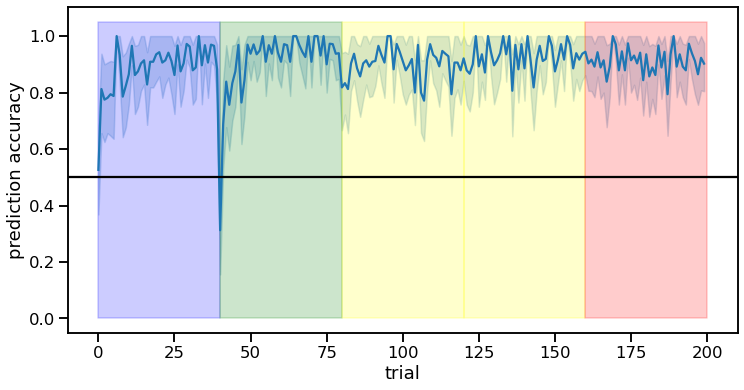

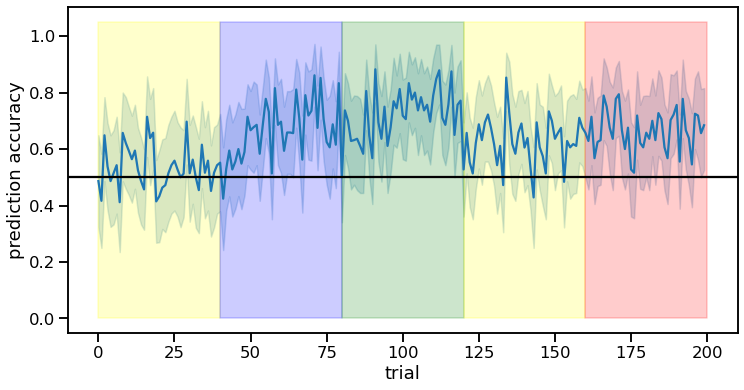

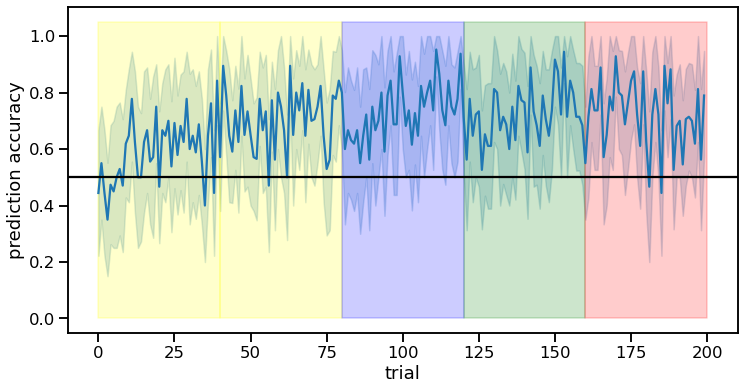

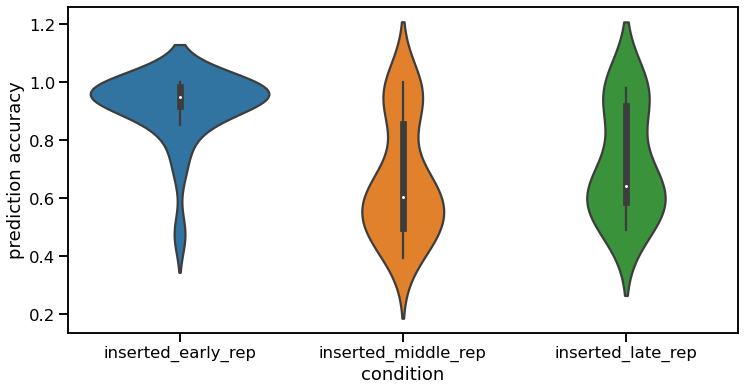

In [36]:
condL = ['inserted_early_rep','inserted_middle_rep','inserted_late_rep']
lineplt(condL,0.9)
beetestplt(condL,0.9)

# Figure S1 a, b, d & e

[0.9]
[0.9]
[0.9]
[0.9]


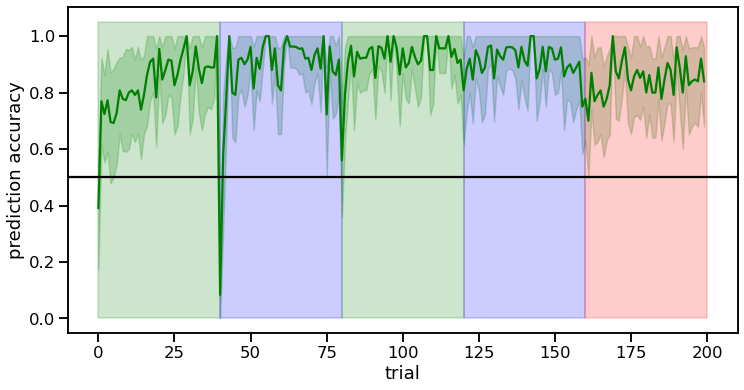

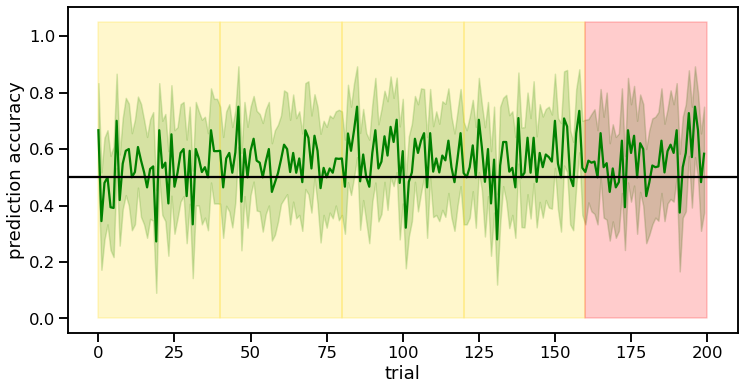

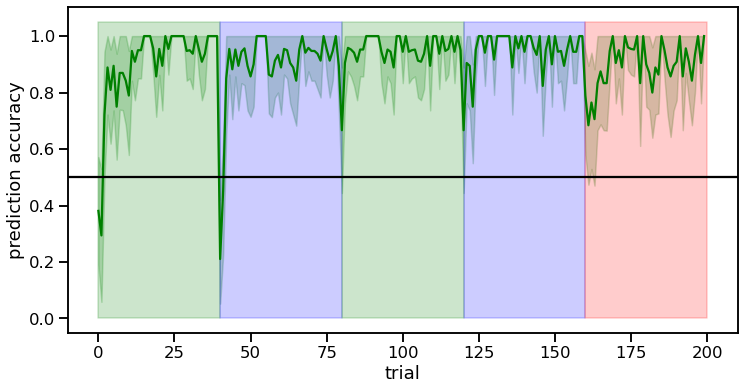

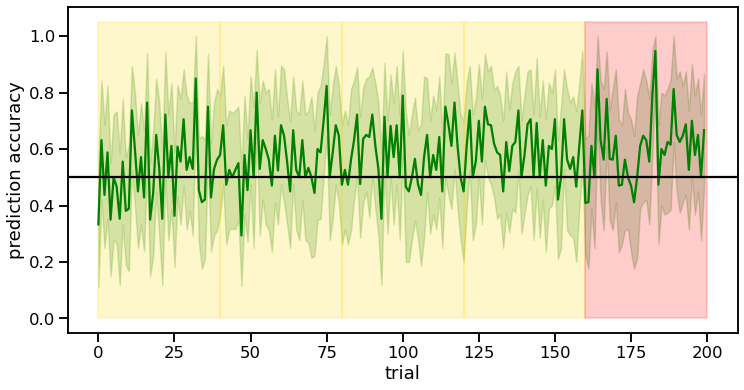

In [37]:
n='trans2'
cL = ["blocked","interleaved","blocked_rep","interleaved_rep"]
lineplt(cL,0.9,transition=1,fgkw={'color':'g'},figname=n)


# Figure S1 c & f

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

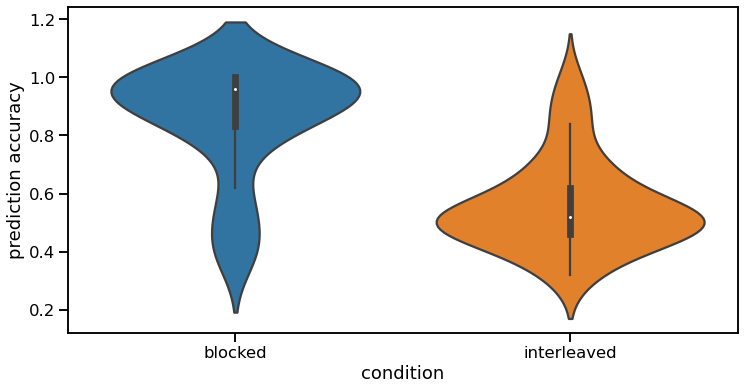

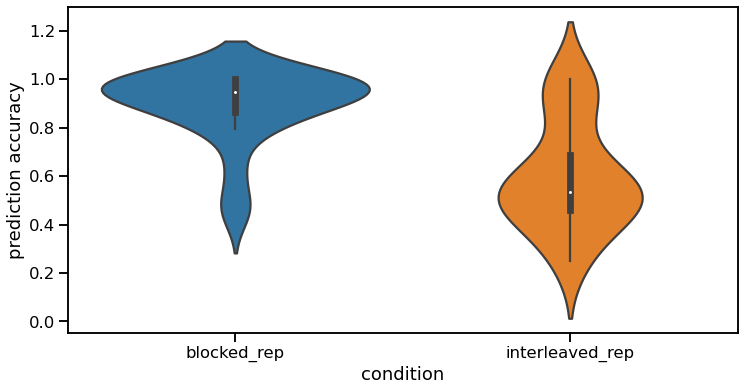

In [38]:
n='trans2'
beetestplt(['blocked','interleaved'],0.9,transition=1,figname=n)
beetestplt(['blocked_rep','interleaved_rep'],0.9,transition=1,figname=n)

# Figure S2 a, b, d, e

[0.9]
[0.9]
[0.9]
[0.9]


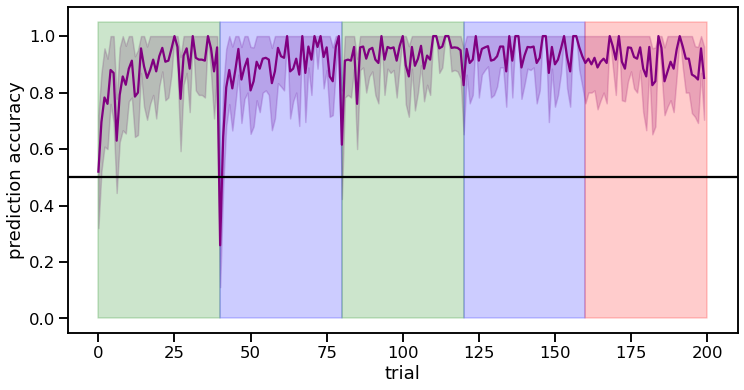

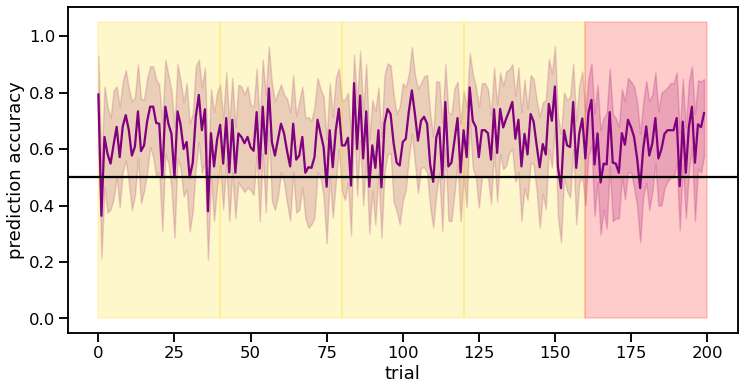

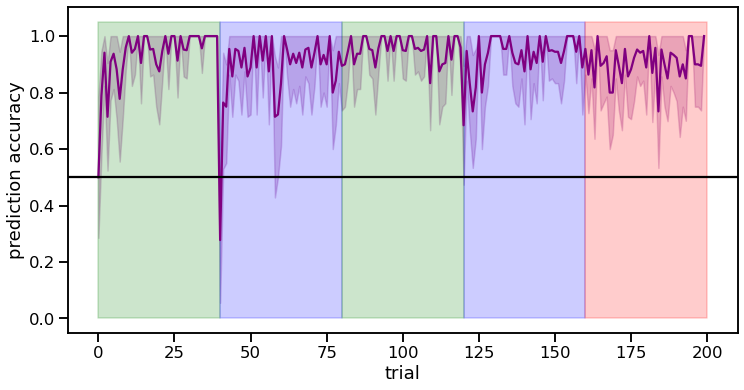

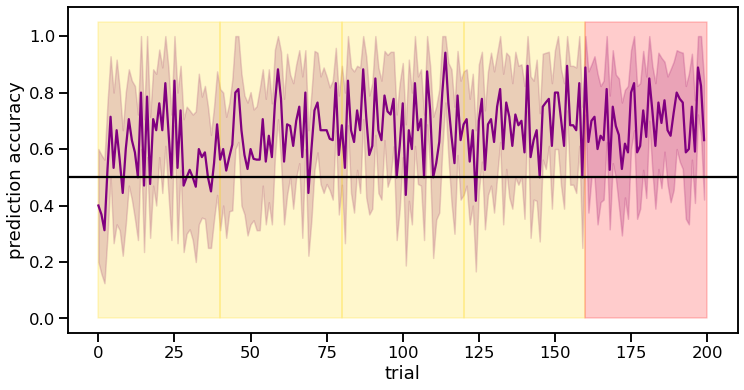

In [39]:
n='trans3'
lineplt(cL,0.9,transition=2,fgkw={'color':'purple'},figname=n)

# Figure S2 c & f

<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

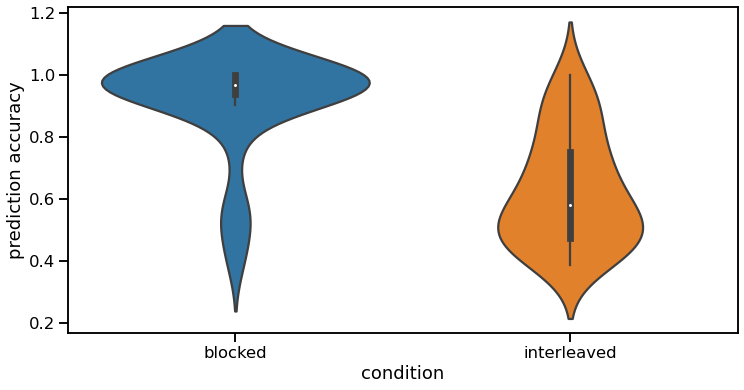

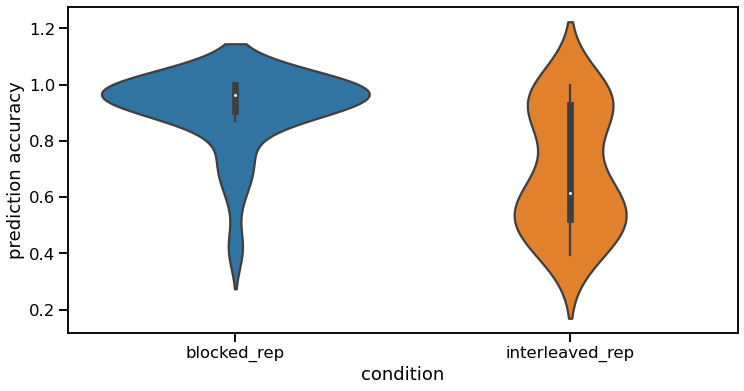

In [40]:
n='trans3'
beetestplt(['blocked','interleaved'],0.9,transition=2,figname=n)
beetestplt(['blocked_rep','interleaved_rep'],0.9,transition=2,figname=n)


# Figure S3 a-c

[0.]
[0.]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

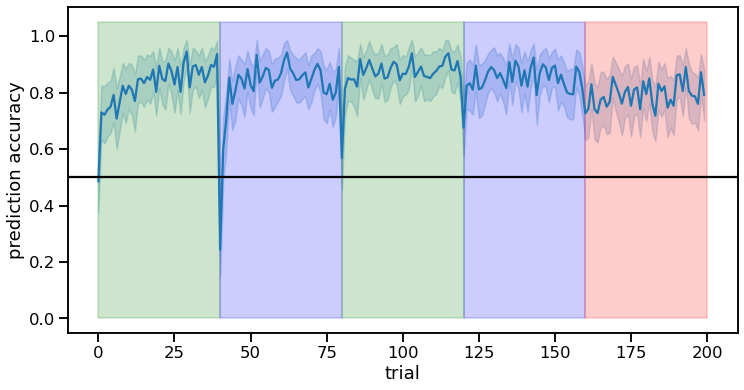

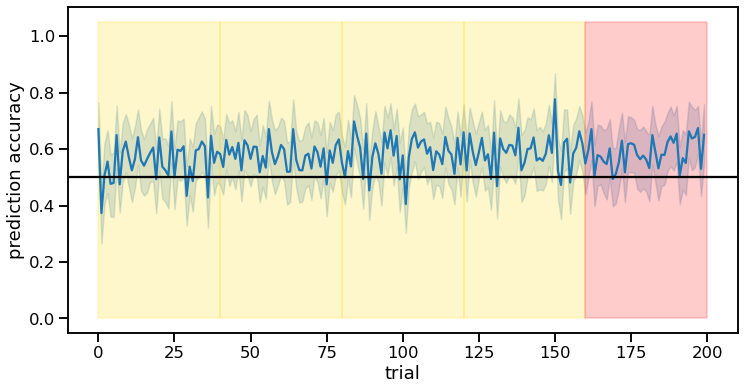

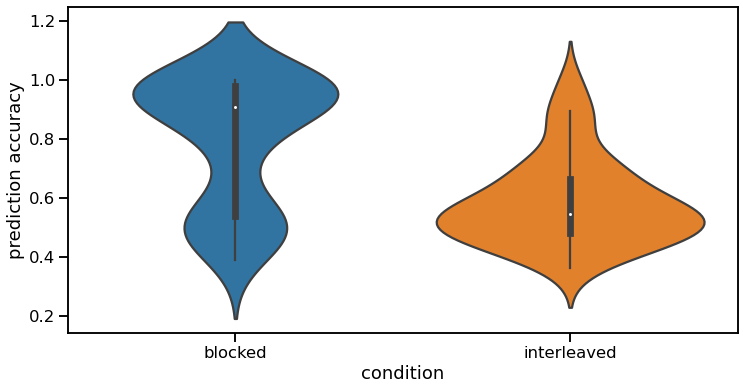

In [41]:
n = 'humanBI'
lineplt(['blocked','interleaved'],0,figname=n)
beetestplt(['blocked','interleaved'],0,figname=n)

# Figure S3 d-f

[0.]
[0.]


<AxesSubplot:xlabel='condition', ylabel='prediction accuracy'>

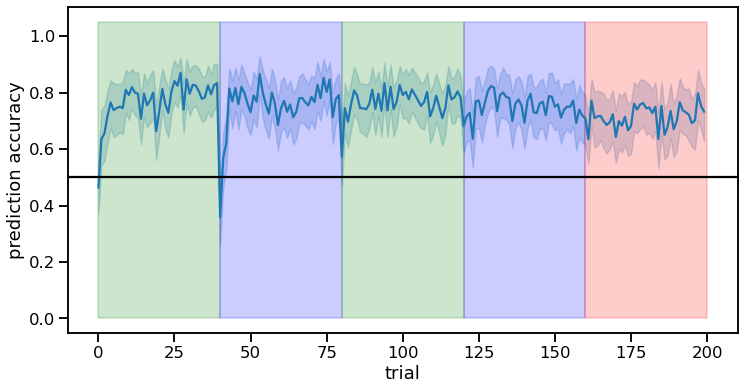

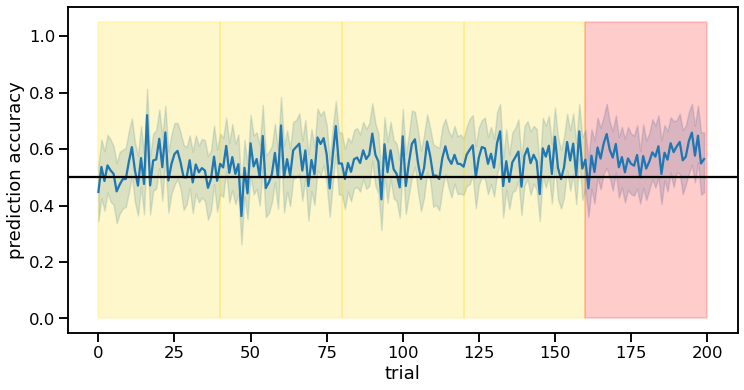

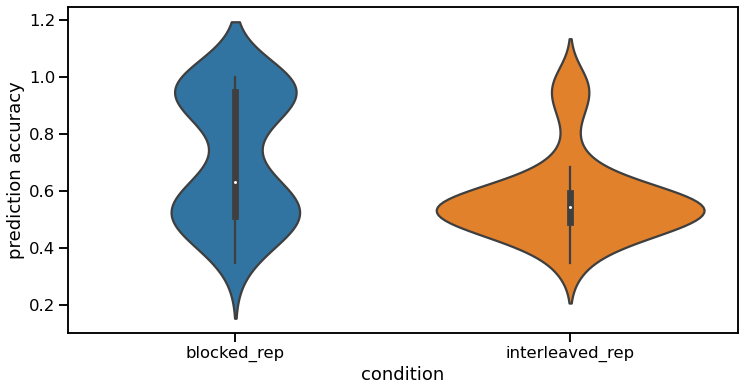

In [42]:
lineplt(['blocked_rep','interleaved_rep'],0)
beetestplt(['blocked_rep','interleaved_rep'],0)

# Figure S4 a-c

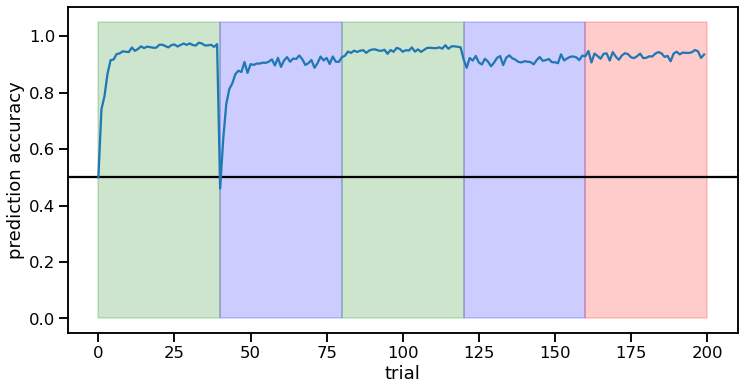

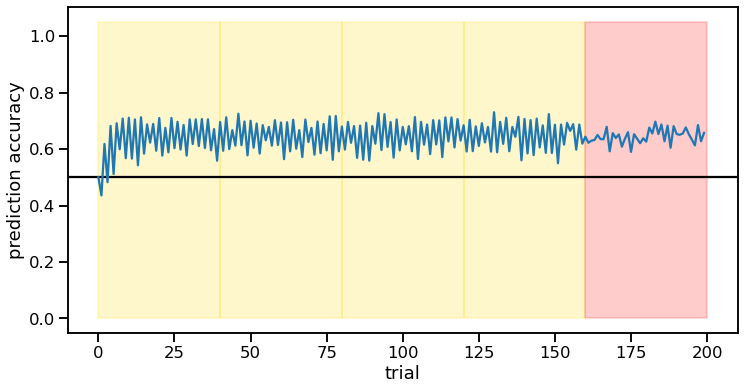

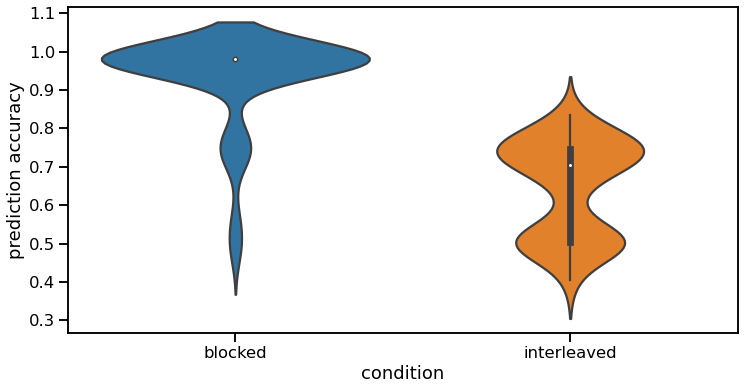

In [43]:
lineplot_modelBI("sim4")
beeswarm_modelBI("sim4")

# Figure S4 d-f

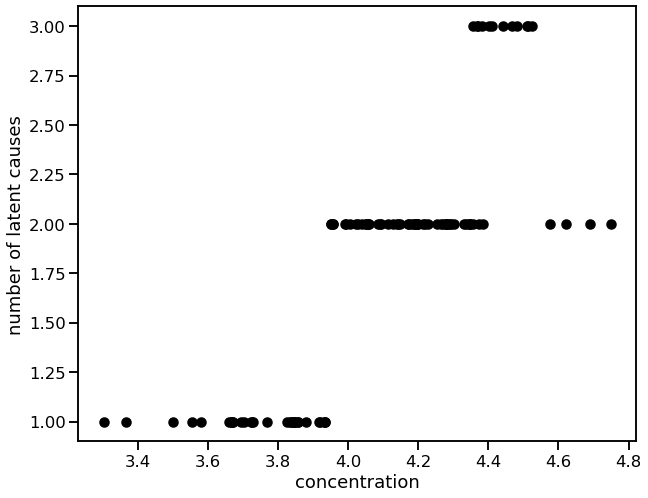

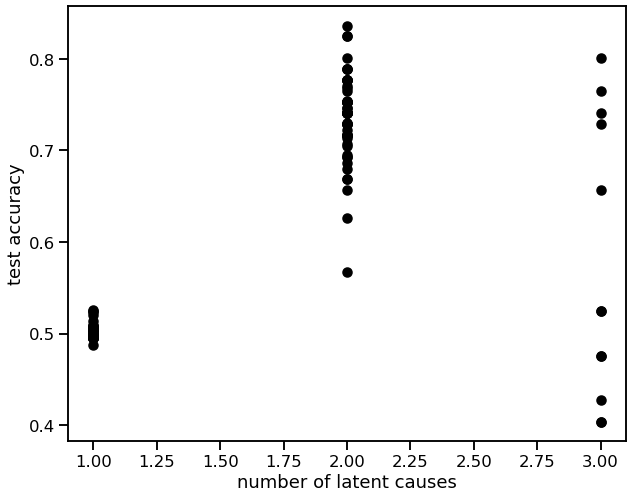

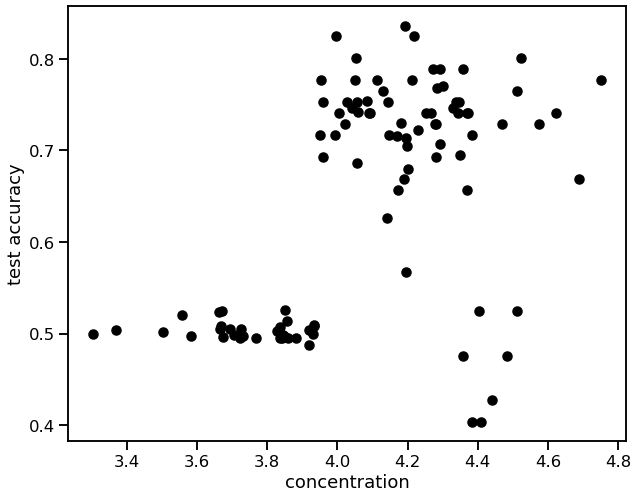

In [44]:
scatter_concentration_vs_numlc("sim4")
scatter_numlc_vs_acc("sim4")
scatter_concentration_vs_acc("sim4")

# Figure S4 g-j

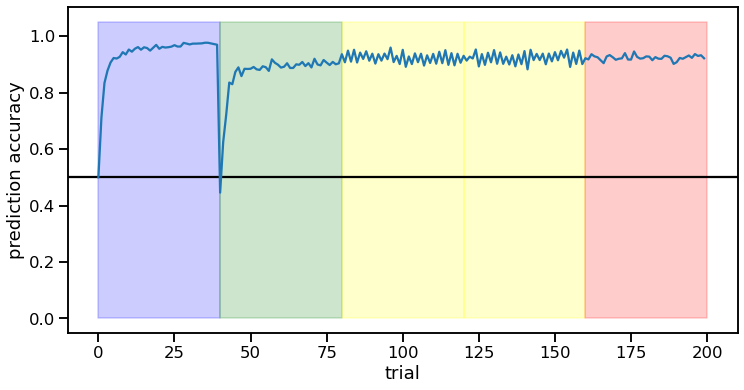

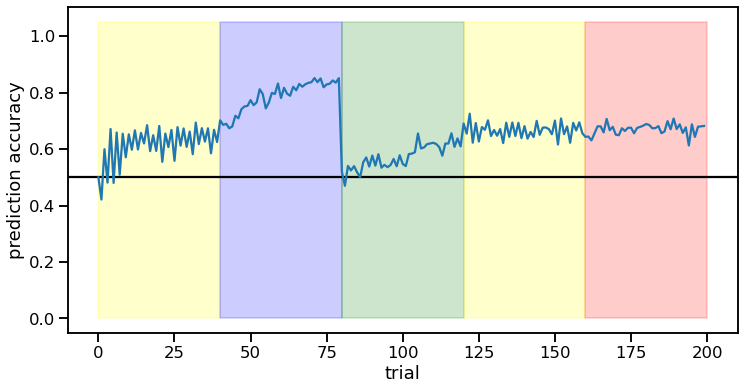

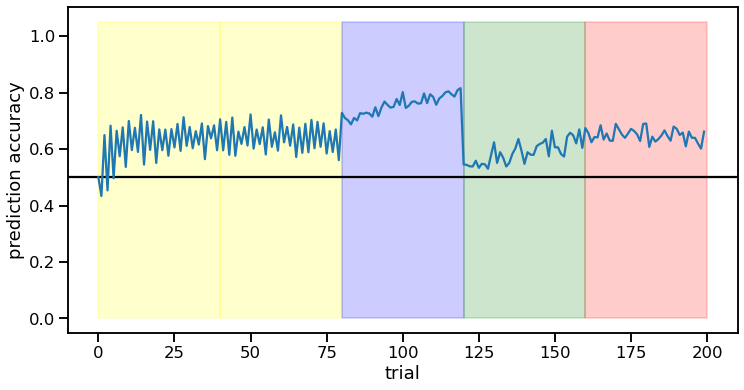

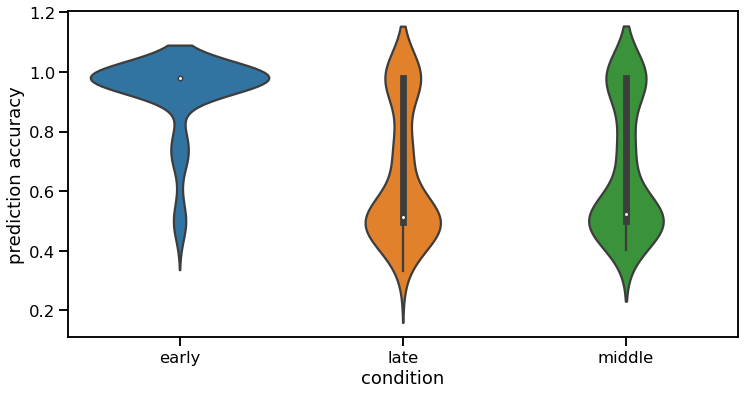

In [45]:
gsname="sim4"
lineplot_modelEML(gsname)
beeswarm_modelEML(gsname)